In [19]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
from web3 import Web3, HTTPProvider
import matplotlib.pyplot as plt


@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo



In [20]:
def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


In [21]:
# raw_data = fetch_curve_markets()
# print("Raw data sample:", raw_data["data"][0])

# # Get formatted DataFrame
# df = get_markets_df()
# print("\nFormatted DataFrame:")
# print(df)

# Get markets hashmap
markets = get_markets_map()

In [22]:
markets

{'wstETH': MarketInfo(address='0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0x37417B2238AA52D0DD2D6252d989E728e8f706e4', rate=0.032969654385967884, total_debt=12508840.186299857, n_loans=85, debt_ceiling=None, borrowable=137494437.9547297, pending_fees=3278.1410295642577, collected_fees=6949295.01963203, collateral_amount=5251.009616338953, collateral_amount_usd=19715084.7876002, stablecoin_amount=20874.032413869943, collateral_token=TokenInfo(symbol='wstETH', address='0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'), stablecoin_token=TokenInfo(symbol='crvUSD', address='0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E')),
 'WBTC': MarketInfo(address='0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0xE0438Eb3703bF871E31Ce639bd351109c88666ea', rate=0.02044131503970914, total_debt=19948803.894962903, n_loans=157, debt_ceiling=None, borrowable=180053406.29274133, p

In [23]:
def fetch_market_snapshots(market_address: str, chain: str = "ethereum", agg: str = "day") -> pd.DataFrame:
    """
    Fetch historical snapshots for a specific crvUSD market
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch snapshots for
    chain : str
        The blockchain network (default: "ethereum")
    agg : str
        Aggregation period - 'day' or 'hour' (default: "day")
    """
    # Ensure we're using checksum address
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}/{market_address}/snapshots"
    params = {
        "fetch_on_chain": "false",
        "agg": agg
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    # Process DataFrame
    if not df.empty:
        # Convert timestamp to datetime
        df['dt'] = pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)
        
        # Convert scientific notation columns to float
        scientific_columns = ['loan_discount', 'liquidation_discount']
        for col in scientific_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by date ascending
        df.sort_index(inplace=True)
    
    return df


In [24]:
# Get market address from our markets map
market_address = "0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE"  # Example address
snapshots_df = fetch_market_snapshots(market_address)

snapshots_df["cr_ratio"] = snapshots_df["total_collateral_usd"] / snapshots_df["total_debt"]
# 30day avg cr_ratio
snapshots_df["cr_ratio_30d"] = snapshots_df["cr_ratio"].rolling(30).mean()
# 7day ema cr_ratio
snapshots_df["cr_ratio_7d"] = snapshots_df["cr_ratio"].rolling(7).mean()
# snapshots_df["cr_ratio_7d"] = snapshots_df["cr_ratio"].ewm(span=7, adjust=False).mean()

snapshots_df["cr_7d/30d"] = snapshots_df["cr_ratio_7d"] / snapshots_df["cr_ratio_30d"]


# Basic info about the data
print("\nDataFrame Info:")
print(snapshots_df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2024-10-07 to 2025-01-14
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rate                  100 non-null    float64
 1   minted                100 non-null    float64
 2   redeemed              100 non-null    float64
 3   total_collateral      100 non-null    float64
 4   total_collateral_usd  100 non-null    float64
 5   total_stablecoin      100 non-null    float64
 6   total_debt            100 non-null    float64
 7   n_loans               100 non-null    int64  
 8   amm_price             100 non-null    float64
 9   price_oracle          100 non-null    float64
 10  base_price            100 non-null    float64
 11  min_band              100 non-null    int64  
 12  max_band              100 non-null    int64  
 13  borrowable            100 non-null    float64
 14  loan_discount         100 non-null    

In [25]:
def plot_market_metrics(df: pd.DataFrame, columns: List[str], title: str = "Market Metrics Over Time", figsize: tuple = (12, 6)):
    """
    Plot multiple metrics from market snapshots over time
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing market snapshots data
    columns : List[str]
        List of column names to plot
    title : str
        Plot title (default: "Market Metrics Over Time")
    figsize : tuple
        Figure size in inches (default: (12, 6))
    """
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot each metric
    for column in columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column, linewidth=2)
        else:
            print(f"Warning: Column '{column}' not found in DataFrame")
    
    # Customize the plot
    plt.title(title, fontsize=14, pad=15)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()


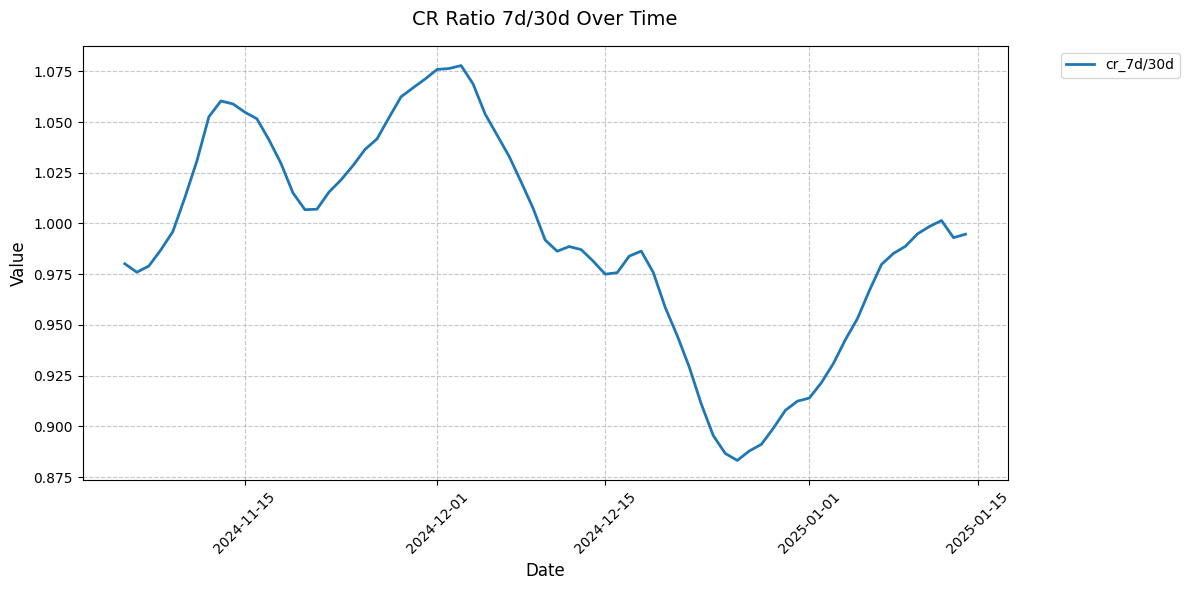

In [26]:
# Plot total debt and collateral amount over time
metrics_to_plot = ['cr_7d/30d']
plot_market_metrics(snapshots_df, metrics_to_plot, "CR Ratio 7d/30d Over Time")


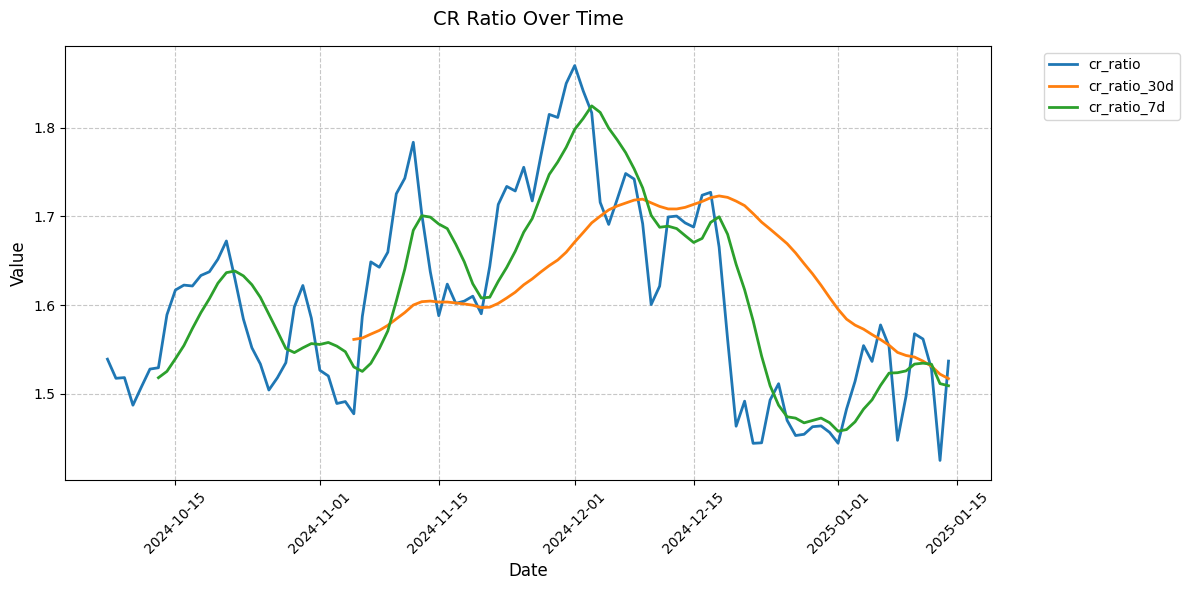

In [27]:
# Plot total debt and collateral amount over time
metrics_to_plot = ['cr_ratio', 'cr_ratio_30d', 'cr_ratio_7d']
plot_market_metrics(snapshots_df, metrics_to_plot, "CR Ratio Over Time")


---

In [28]:
import os
from dotenv import load_dotenv
from web3 import Web3, HTTPProvider

# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='.env')

# Create the Web3 provider using the Alchemy URL
w3 = Web3(HTTPProvider(os.getenv('BLOCKPI_ETH'))) # BASE

# Check connection
print(f"Web3 is connected: {w3.is_connected()}")

Web3 is connected: True


In [29]:
def get_A(amm_address: str) -> float:
    
    abi = [
        {"stateMutability":"view","type":"function","name":"A","inputs":[],"outputs":[{"name":"arg_0","type":"uint256"}]}
    ]
    
    contract_address = Web3.to_checksum_address(amm_address)
    
    contract = w3.eth.contract(address=contract_address, abi=abi)
    result = contract.functions.A().call()
    return result


In [30]:
market_df_dict = {}
cr_score_dict = {}

for market, market_info in markets.items():
    
    market_cr_score = {}
    
    snapshots_df = fetch_market_snapshots(market_info.address)

    snapshots_df["cr_ratio"] = snapshots_df["total_collateral_usd"] / snapshots_df["total_debt"]
    # 30day avg cr_ratio
    snapshots_df["cr_ratio_30d"] = snapshots_df["cr_ratio"].rolling(30).mean()
    # 7day ema cr_ratio
    snapshots_df["cr_ratio_7d"] = snapshots_df["cr_ratio"].rolling(7).mean()

    snapshots_df["cr_7d/30d"] = snapshots_df["cr_ratio_7d"] / snapshots_df["cr_ratio_30d"]
    
    latest_row = snapshots_df.iloc[-1]
    amp = get_A(market_info.llamma)
    market_cr_score["A"] = amp
    ld = float(latest_row["liquidation_discount"])/1e18
    market_cr_score["liquidation_discount"] = ld
    market_cr_score["cr_7d/30d"] = latest_row["cr_7d/30d"]
    min_ltv = 1 - ld - (2 / amp)
    max_ltv = 1 - ld - (25 / amp)
    market_cr_score["min_ltv"] = min_ltv
    market_cr_score["max_ltv"] = max_ltv
    market_cr_score["current_cr"] = latest_row["cr_ratio"]
    

    cr_score_dict[market] = market_cr_score
    
    market_df_dict[market] = snapshots_df

In [31]:
def plot_market_cr_analysis(market_key: str, market_df_dict: dict, figsize: tuple = (12, 6)):
    """
    Plot CR ratio analysis charts for a specific market
    
    Parameters:
    -----------
    market_key : str
        The market key (e.g., 'WBTC', 'WETH', etc.) to plot data for
    market_df_dict : dict
        Dictionary containing market DataFrames
    figsize : tuple
        Figure size for each plot (default: (12, 6))
    """
    if market_key not in market_df_dict:
        print(f"Error: Market '{market_key}' not found in market_df_dict")
        return
    
    df = market_df_dict[market_key]
    
    # # Plot 1: CR Ratios
    # metrics_to_plot = ['cr_ratio', 'cr_ratio_30d', 'cr_ratio_7d']
    # plot_market_metrics(df, metrics_to_plot, 
    #                    f"{market_key} CR Ratio Over Time",
    #                    figsize=figsize)
    
    # Plot 2: 7d/30d Ratio
    metrics_to_plot = ['cr_7d/30d']
    plot_market_metrics(df, metrics_to_plot, 
                       f"{market_key} CR Ratio 7d/30d Over Time",
                       figsize=figsize)


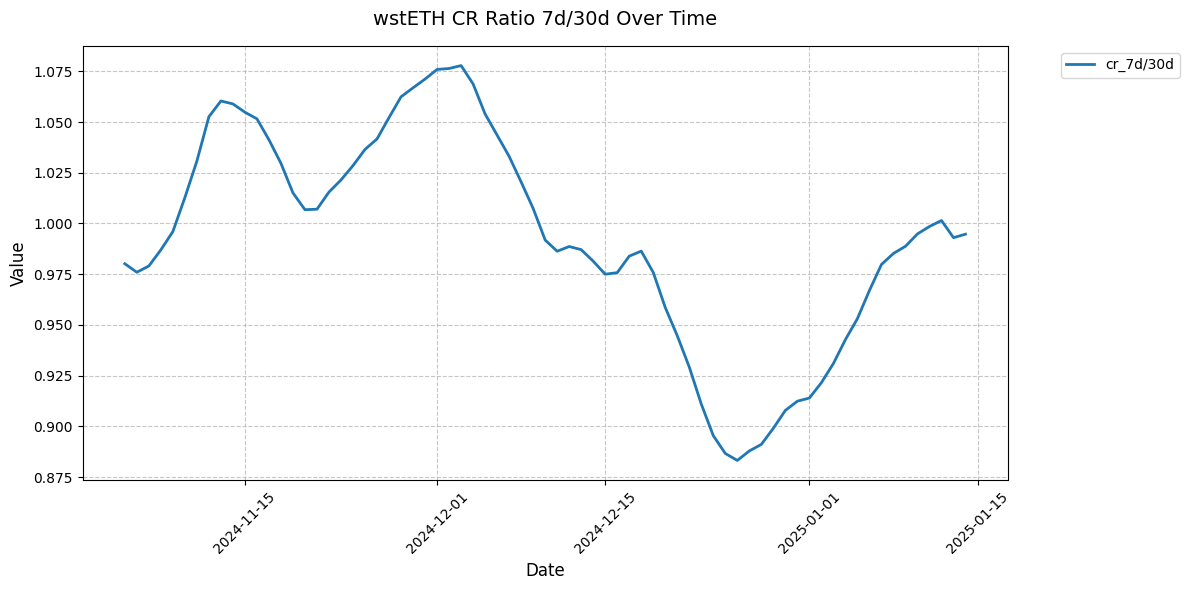

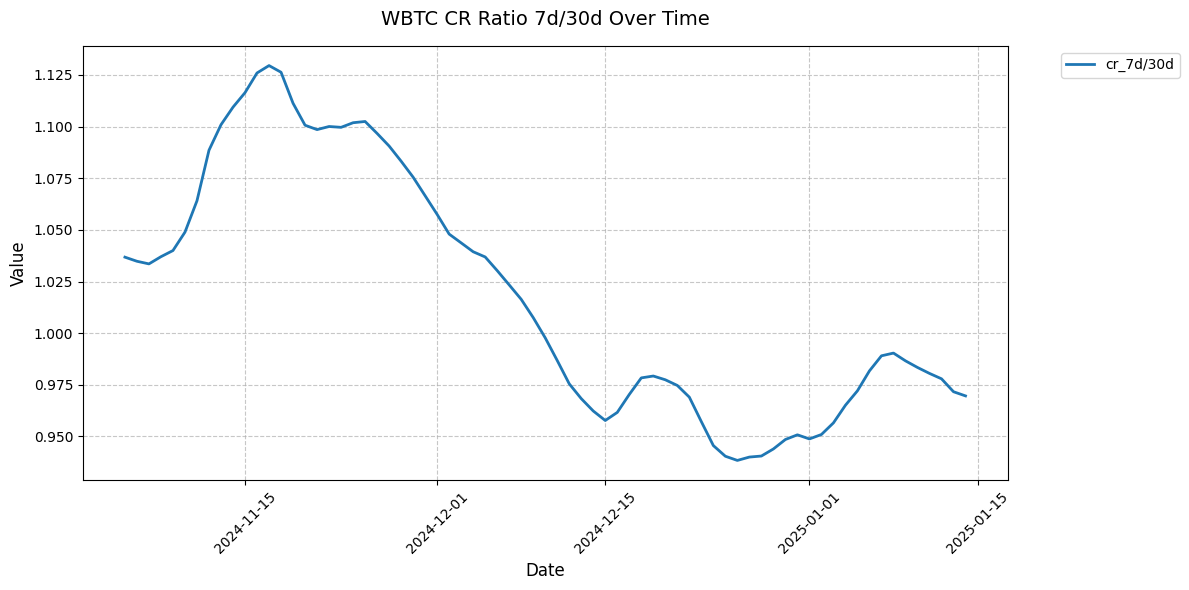

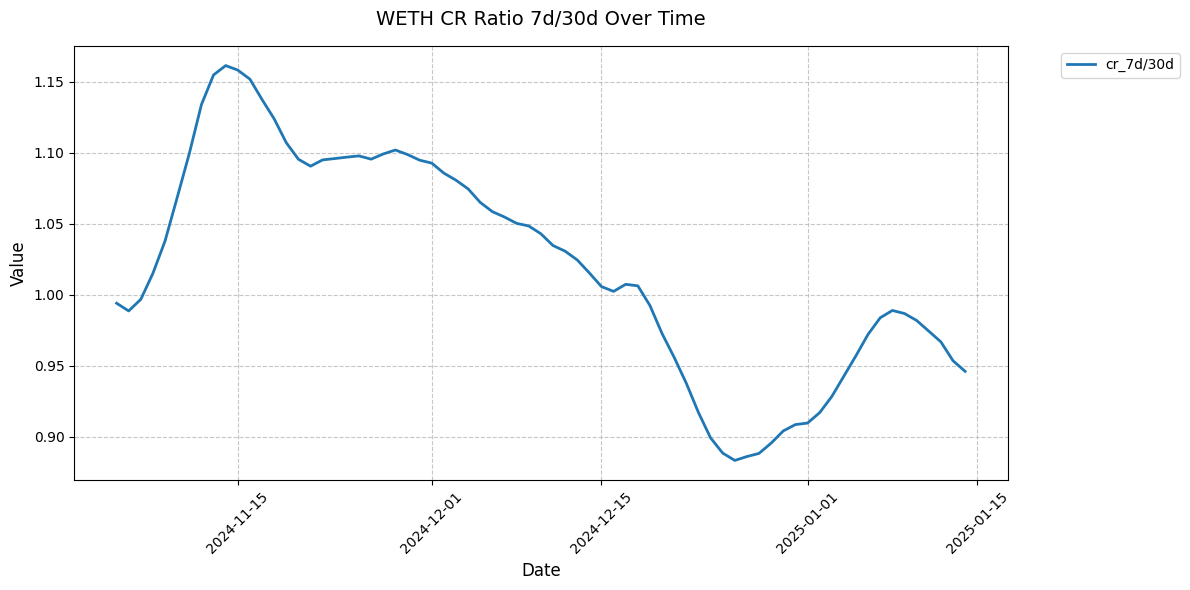

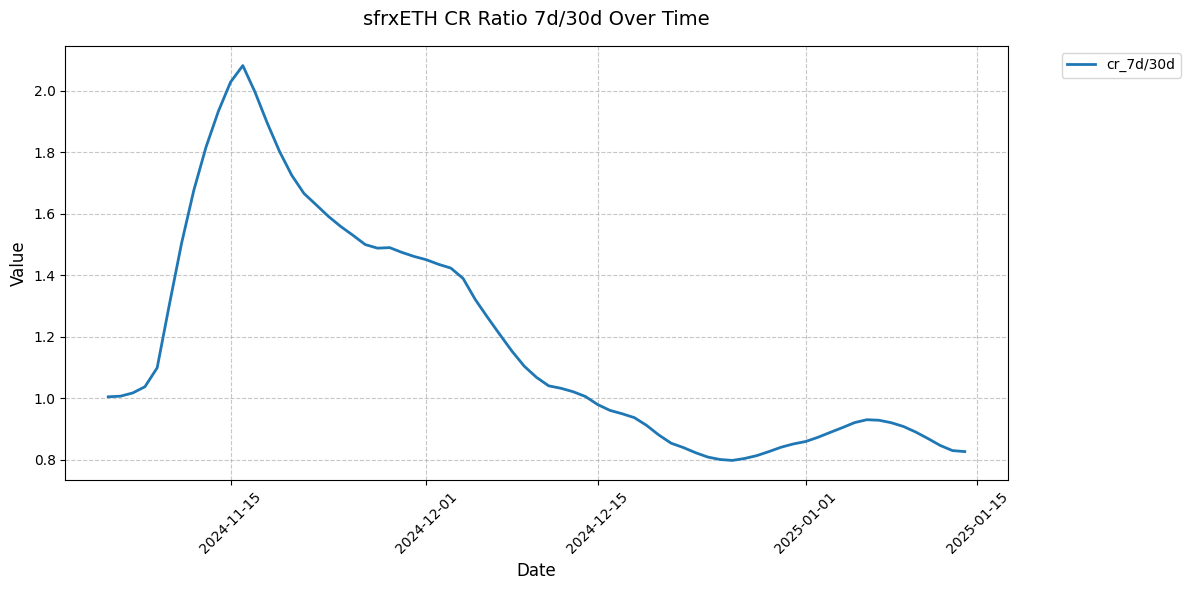

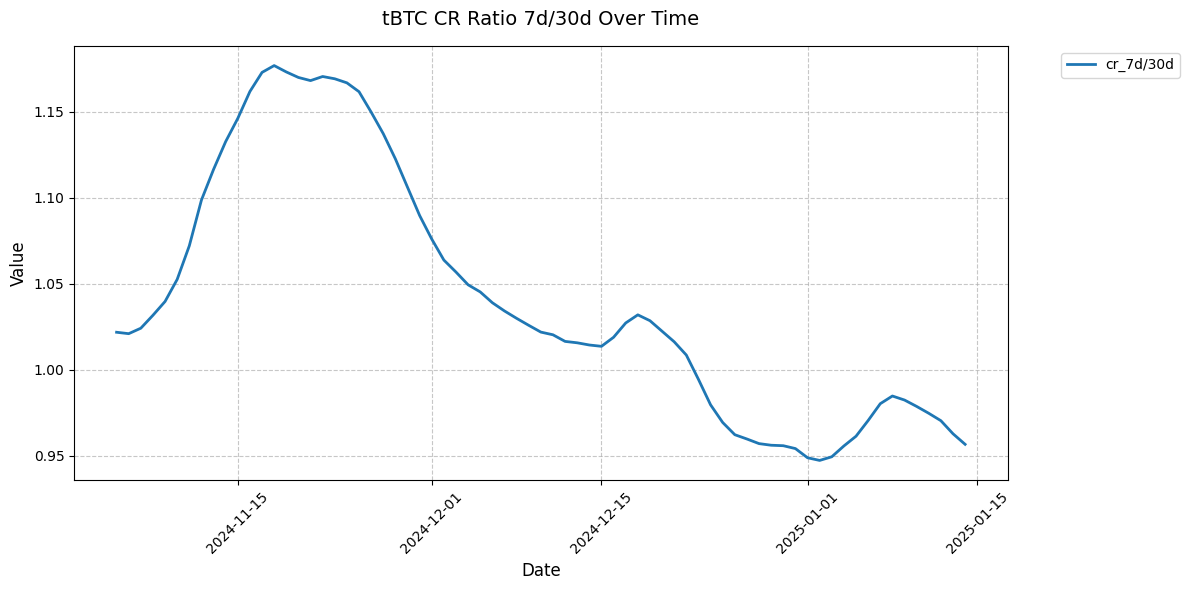

In [32]:
for market, market_info in markets.items():
    plot_market_cr_analysis(market, market_df_dict)

In [33]:
cr_score_dict

{'wstETH': {'A': 100,
  'liquidation_discount': 0.06,
  'cr_7d/30d': np.float64(0.9947140271844249),
  'min_ltv': 0.9199999999999999,
  'max_ltv': 0.69,
  'current_cr': np.float64(1.5369966956143182)},
 'WBTC': {'A': 100,
  'liquidation_discount': 0.06,
  'cr_7d/30d': np.float64(0.9696332097663191),
  'min_ltv': 0.9199999999999999,
  'max_ltv': 0.69,
  'current_cr': np.float64(2.0301857730016177)},
 'WETH': {'A': 100,
  'liquidation_discount': 0.06,
  'cr_7d/30d': np.float64(0.946059270117972),
  'min_ltv': 0.9199999999999999,
  'max_ltv': 0.69,
  'current_cr': np.float64(1.6223205539467709)},
 'sfrxETH': {'A': 100,
  'liquidation_discount': 0.06,
  'cr_7d/30d': np.float64(0.8265163401358792),
  'min_ltv': 0.9199999999999999,
  'max_ltv': 0.69,
  'current_cr': np.float64(4.425445698748736)},
 'tBTC': {'A': 100,
  'liquidation_discount': 0.06,
  'cr_7d/30d': np.float64(0.9567370847793144),
  'min_ltv': 0.9199999999999999,
  'max_ltv': 0.69,
  'current_cr': np.float64(2.4366495894209264)

In [34]:
def score_with_limits(score_this: float,
                      upper_limit: float,
                      lower_limit: float,
                      direction: bool,
                      mid_limit: float = None) -> float:
    """
    Score the market based on the collateral ratio comparison

    Args:
        score_this (float): Value to be scored
        upper_limit (float): Upper boundary for scoring
        lower_limit (float): Lower boundary for scoring
        mid_limit (float): Middle point representing 0.5 score
        direction (bool): If True, higher values get higher scores
                        If False, lower values get higher scores

    Returns:
        float: Score between 0 and 1
    """

    if mid_limit is None:
        mid_limit = (upper_limit + lower_limit) / 2

    if direction:
        if score_this >= upper_limit:
            return 1.0
        elif score_this <= lower_limit:
            return 0.0
        else:
            # Score between lower and mid
            if score_this <= mid_limit:
                return 0.5 * (score_this - lower_limit) / (mid_limit - lower_limit)
            # Score between mid and upper
            else:
                return 0.5 + 0.5 * (score_this - mid_limit) / (upper_limit - mid_limit)
    else:
        if score_this >= upper_limit:
            return 0.0
        elif score_this <= lower_limit:
            return 1.0
        else:
            # Score between lower and mid
            if score_this <= mid_limit:
                return 1.0 - 0.5 * (score_this - lower_limit) / (mid_limit - lower_limit)
            # Score between mid and upper
            else:
                return 0.5 - 0.5 * (score_this - mid_limit) / (upper_limit - mid_limit)

    # Ensure score is between 0 and 1
    return max(0.0, min(1.0, score))

In [35]:
print("Market CR Score Analysis")
print("=" * 40)

for market, data in cr_score_dict.items():
    # Calculate scores
    relative_cr_score = score_with_limits(data['cr_7d/30d'], 1.1, 0.9, True)
    absolute_cr_score = score_with_limits(data['current_cr'], 
                                        0.01/(0.75 * data['min_ltv']), 
                                        0.01/(0.75 * data['max_ltv']), 
                                        True)
    aggregate_cr_score = (0.4 * relative_cr_score + 0.6 * absolute_cr_score)
    
    print(f"\n{market}")
    print("-" * 40)
    print(f"Current CR:     {data['current_cr']:.3f}")
    print(f"CR 7d/30d:      {data['cr_7d/30d']:.3f}")
    print(f"LTV Range:      {data['min_ltv']:.1%} - {data['max_ltv']:.1%}")
    print(f"LTV Range Bounds:      {0.75 * data['min_ltv']:.1%} - {0.75 * data['max_ltv']:.1%}")
    print(f"CR Range:      {1/data['min_ltv']:.1%} - {1/data['max_ltv']:.1%}")
    print(f"CR Range Bounds:      {1/(0.75 * data['min_ltv']):.1%} - {1/(0.75 * data['max_ltv']):.1%}")
    
    print(f"Scores:")
    print(f"  Relative:     {relative_cr_score:.1%}    (7d/30d ratio)")
    print(f"  Absolute:     {absolute_cr_score:.1%}    (current CR vs LTV limits)")
    print(f"  Final Score:  {aggregate_cr_score:.1%}    (0.4 * Relative + 0.6 * Absolute)")

Market CR Score Analysis

wstETH
----------------------------------------
Current CR:     1.537
CR 7d/30d:      0.995
LTV Range:      92.0% - 69.0%
LTV Range Bounds:      69.0% - 51.7%
CR Range:      108.7% - 144.9%
CR Range Bounds:      144.9% - 193.2%
Scores:
  Relative:     47.4%    (7d/30d ratio)
  Absolute:     100.0%    (current CR vs LTV limits)
  Final Score:  78.9%    (0.4 * Relative + 0.6 * Absolute)

WBTC
----------------------------------------
Current CR:     2.030
CR 7d/30d:      0.970
LTV Range:      92.0% - 69.0%
LTV Range Bounds:      69.0% - 51.7%
CR Range:      108.7% - 144.9%
CR Range Bounds:      144.9% - 193.2%
Scores:
  Relative:     34.8%    (7d/30d ratio)
  Absolute:     100.0%    (current CR vs LTV limits)
  Final Score:  73.9%    (0.4 * Relative + 0.6 * Absolute)

WETH
----------------------------------------
Current CR:     1.622
CR 7d/30d:      0.946
LTV Range:      92.0% - 69.0%
LTV Range Bounds:      69.0% - 51.7%
CR Range:      108.7% - 144.9%
CR Range B